<h1>Real Time Audio Klassifizierung</h1>

Hier wollen wir ein Model erstellen, dass Sound klassifizieren soll. Dan soll das Model in Echtzeit Klassifizierungen durchführen.

Als Startpunkt orientieren wir uns an dem Notebook TF_Audio.

Als zusätzliche Aufgabe sollen die betroffenen stellen der Sounds markiert werden.

Um den Anfang zu machen, wollen wir als Ziel ein Model trainieren, dass Wörter erkennen soll.:
- Ein ASR Model (Automatic-speech-recognition)

Als Dataset nutzen wir:
> Speech Commands dataset (Warden, 2018) <br>
> https://www.tensorflow.org/datasets/catalog/speech_commands [Letzter Zugriff: 5.09.2024]

Dieses Dataset enthält folgende Wörter im Audioformat: "down", "go", "left", "no", "right", "stop", "up" und "yes" <br>

In [29]:
# Imports 
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

import IPython
from IPython import display

import sounddevice as sd
import librosa
from scipy.io import wavfile
import wave

Lade Dataset herunter.

In [107]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

In [108]:
# Dataset enthält Ordner mit Audiodateien.
commands = np.array(tf.io.gfile.listdir(str(data_dir)))

commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print(f'Kommandos: {commands}')

Kommandos: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [109]:
# Erstelle Dataset # 
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=32,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,  # Padding 
    subset='both')
train_ds

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.


<_BatchDataset element_spec=(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [5]:
label_names = train_ds.class_names
train_ds.class_names

['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes']

Alternativ können auch nur einige dieser Kommandos oder andere verwendet werden.

<h2>Audio File Analyse</h2>

Dafür eignen sich viele Libraries, generell.:
- scipy
- wave

In [103]:
random_command = np.random.randint(1, len(label_names)-1)
random_command = label_names[random_command]

listed_audio_files = os.listdir(DATASET_PATH+f"/{random_command}")

samplerate, data = wavfile.read(DATASET_PATH+f"/{random_command}/{listed_audio_files[6]}")
print(f"Kommando: {random_command}")
print(f"number of channels = {data.shape[0]}")

length = data.shape[0] / samplerate
print(f"Länge = {length}s")

Kommando: right
number of channels = 16000
Länge = 1.0s


<b>Samplerate</b>: Samples pro Sekunde (Hz)<br>
<b>Data</b>: Stellt die Amplitude der Schallwellen bei jedem Sample dar. Die Struktur ist abhängig von der Anzahl der Channels (mono, stereo) und der Bittiefe. <br>
Mono: 1D, Stereo: 2D, für rechts und links.

Die Bittiefe beschreibt die Range und Genauigkeit der Werte. Jedes Sample repräsentiert durch die Amplitude wie laut es ist. Bei einer Tiefe von 16-Bit sind also 2^16 Werte möglich.

In [75]:
samplerate

16000

In [76]:
data[:10]

array([-1, -2, -1,  1, -1,  1,  2,  2,  2,  2], dtype=int16)

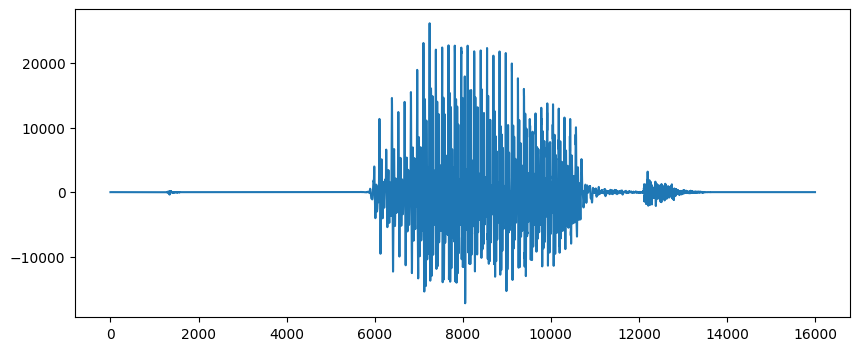

In [77]:
plt.figure(figsize=(10,4))
plt.plot(data)

In [78]:
# Mit Wave # 
wave_audiofile = wave.Wave_read(DATASET_PATH+f"/{random_command}/{listed_audio_files[6]}")

In [79]:
wave_audiofile.getnchannels()
# Auch:
# - max
# - frame_rate
# ...

1

In [80]:
wave_audiofile.getframerate()

16000

Die Channels beschreiben dabei mono oder stereo. Ein Audiosignal was in waveform vorliegt, kann in ein Spektrogramm umgeformt werden, was das Signal in x: Zeit und y: Frequenz aufteilt (siehe Plot), die Pixelwerte geben dabei Stärke der Sounds an, was man auch Dezibel nennt. Da ein Spektrogramm als 2D Bild vorliegt, können herkömmliche CNNs verwendet werden. Da Audio eine Sequenz darstellt, können RNNs und CNN-RNNs verwendet werden.

Genau das ist ein gutes Beispiel für die Verwendung von RNNs bei Bilddaten.

- Vergiss nicht zu normalisieren und zu Argumentieren

In [81]:
# Wandel in Spektrogramm um #
def get_spectrogram(waveform):
    # Short-Time Fourier Transformation: Analysiere Frequenz 
    # - Teile Signal in Frames ein, wende auf Frame Fourier Transformation an.
    # - frame_length: nehme n-Samples für den Frame
    # - frame_step: Overlapping. Seichterer Übergang. 
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    # Ergebnis sind komplexe Zahlen => berechne Betrag der Zahlen.
    # - Phasenifnromationen werden verworfen und Amplitude behalten
    #   Reich oft für Analyse des Frequenzinhalts.
    spectrogram = tf.abs(spectrogram)  # 2D Repräsentation 
    # Füge eine Achse hinzu, da z. B. CNN ein 3D Tensor erwartet. 
    # - Statt RGB 3D Channel ist es hier ein Greyscale 1D Channel.
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

In [126]:
def plot_spectrogram(spectrogram):
      if len(spectrogram.shape) > 2:
            assert len(spectrogram.shape) == 3
      spectrogram = np.squeeze(spectrogram, axis=-1)
      spectrogram = np.squeeze(spectrogram, axis=-1)
      # Transponiere: x: Zeit
      # Füge Eps. hinzu, dmait nicht log(0).
      log_spec = np.log(spectrogram.T + np.finfo(float).eps)
      height = log_spec.shape[0]
      width = log_spec.shape[1]
      X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
      Y = range(height)
      plt.pcolormesh(X, Y, log_spec)

In [142]:
# Erstelle Dataset # 
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=32,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,  # Padding 
    subset='both')
train_ds

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.


<_BatchDataset element_spec=(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [143]:
# Entferne eine Achse, da Single-Channel # 
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds   = val_ds.map(squeeze, tf.data.AUTOTUNE)

<h2>Dataset vorbereiten und Model</h2>

In [83]:
# Entferne eine Achse, da Single-Channel # 
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds   = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [48]:
# Erstelle Test- und Validationset mit Shards #
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds  = val_ds.shard(num_shards=2, index=1)

In [49]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [50]:
train_ds_spec = make_spec_ds(train_ds)
val_ds_spec   = make_spec_ds(val_ds)
test_ds_spec  = make_spec_ds(test_ds)

Dann erstellen wir das Model.

In [51]:
for example_spectrograms, example_spect_labels in train_ds_spec.take(1):
  break

In [41]:
input_shape

TensorShape([124, 129, 1])

In [54]:
example_spectrograms.shape[0]

32

In [68]:

input_shape = example_spectrograms.shape[1:]
num_labels  = len(label_names)

norm_layer = tf.keras.layers.Normalization()
norm_layer.adapt(data=train_ds_spec.map(map_func=lambda spec, label: spec))

sound_model = tf.keras.Sequential([
    
    #tf.keras.layers.Input(shape=(124, 129, 1)),
   
    norm_layer,
    tf.keras.layers.Reshape((124, 129 )),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(128, return_sequences=False),

    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(num_labels, activation="softmax")
])

tb_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/sound_realtime/sound_model", histogram_freq=1)

sound_model.compile(
    optimizer="adam",
    loss     = tf.keras.losses.SparseCategoricalCrossentropy,
    metrics  = ["accuracy"]
)

In [69]:
sound_model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_18                │ (None, 124, 129, 1)    │             3 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_30 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3 (16.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3 (16.00 B)

In [70]:
sound_m_history = sound_model.fit(train_ds_spec, validation_data=val_ds_spec, callbacks=[tb_callback], epochs=30)

Epoch 1/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 17s 71ms/step - accuracy: 0.2035 - loss: 1.9843 - val_accuracy: 0.3288 - val_loss: 1.8446
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.2878 - loss: 1.8223 - val_accuracy: 0.3262 - val_loss: 1.7359
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.3057 - loss: 1.8101 - val_accuracy: 0.3963 - val_loss: 1.5781
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.3670 - loss: 1.6419 - val_accuracy: 0.4750 - val_loss: 1.3817
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.4484 - loss: 1.4432 - val_accuracy: 0.4888 - val_loss: 1.3370
Epoch 6/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.5452 - loss: 1.2377 - val_accuracy: 0.5838 - val_loss: 1.1543
Epoch 7/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.6026 - loss: 1.1132 - val_accuracy: 0.6413 - val_loss: 1.0009
Epoch 8/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.6048 - loss: 1.0809 - 